In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import sys
import time

In [2]:
def is_season_day(m, d):
    '''
    Returns True if the given date is both in `year` and is in the
    defined (May 10-Oct 20) growing season.
    '''
    return ((m == 5) & (d >= 10)) | ((m >= 6) & (m <= 9)) | ((m == 10) & (d <= 20))

monlen = [0,31,28,31,30,31,30,31,31,30,31,30,31]

season_days = []
for m in range(1,13):
    for d in range(1, monlen[m] + 1):
        if is_season_day(m, d):
            season_days += [(m, d)]

In [3]:
def sample_5cd(data, month, day, year0, yearn):
    '''
    Return the 5CD slice (5 contiuous days centered around the given date,
    over the base period) for the given calendar day.
    '''
    agg = []
    for year in range(year0, yearn):
        center = data[(data.YEAR == year) & (data.MONTH == month) & (data.DAY == day)].index[0]
        agg.append(data.loc[int(center-2):int(center+2)])
    return pd.concat(agg)

In [4]:
def streak(lst):
    '''
    Returns the longest contiguous streak of truthy values in `lst`
    '''
    best = 0
    count = 0

    for v in lst:
        if v:
            count += 1
            best = max(best, count)
        else:
            count = 0

    return best

,YEAR,YIELD
YEAR,1.000000,0.937928
YIELD,0.937928,1.000000


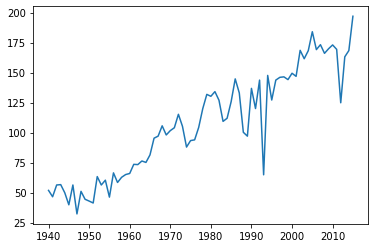

In [5]:
ag = pd.read_csv('../data/agri/frontiers/Processed_Iowa+Cerro+Gordo_1960+2009_Annual+Crop.csv')
ag = ag.sort_values('Year')
corn = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'CORN')].copy()
corn['YEAR'] = corn.Year
corn['YIELD'] = corn.Value.astype('float')
corn = corn[['YEAR', 'YIELD']]
plt.plot(corn.YEAR, corn.YIELD)
corn.corr()

In [6]:
data = ['USC00135230.csv', 'USC00137572.csv', 'USW00014940.csv']
dataroot = '../data/wx/ghcnd'
data = map(lambda x: path.join(dataroot, x), data)
data = [pd.read_csv(d, low_memory=False) for d in data]

prcp = [df[['DATE', 'PRCP']] for df in data]

prcpdf = prcp[0].merge(prcp[1], on='DATE', how='outer')
prcpdf = prcpdf.merge(prcp[2], on='DATE', how='outer')

prcpdf['PRCP'] = prcpdf[['PRCP_x', 'PRCP_y', 'PRCP']].mean(axis = 1)
prcpdf.PRCP = prcpdf.PRCP * 0.1
prcpdf = prcpdf.drop(['PRCP_x', 'PRCP_y'], axis=1)

prcpdf.DATE = pd.to_datetime(prcpdf.DATE)
prcpdf.sort_values('DATE', inplace=True)
prcpdf['YEAR'] = prcpdf.DATE.map(lambda d: d.year)
prcpdf['MONTH'] = prcpdf.DATE.map(lambda d: d.month)
prcpdf['DAY'] = prcpdf.DATE.map(lambda d: d.day)
prcpdf = prcpdf[(prcpdf.YEAR >= 1941) & (prcpdf.YEAR <= 2015)]
prcpseasdf = prcpdf.loc[is_season_day(prcpdf.MONTH, prcpdf.DAY)].copy()
prcpseasdf

,DATE,PRCP,YEAR,MONTH,DAY
16206,1941-05-10,0.0,1941,5,10
16207,1941-05-11,0.0,1941,5,11
16208,1941-05-12,0.0,1941,5,12
16209,1941-05-13,0.0,1941,5,13
16210,1941-05-14,0.0,1941,5,14
...,...,...,...,...,...
42902,2015-10-16,0.0,2015,10,16
42903,2015-10-17,0.0,2015,10,17
42904,2015-10-18,0.0,2015,10,18
42905,2015-10-19,0.0,2015,10,19


In [7]:
temp = [df[['DATE', 'TMIN', 'TMAX']] for df in [data[0], data[2]]]

tempdf = temp[0].merge(temp[1], on='DATE', how='outer')

tempdf['TMIN'] = tempdf[['TMIN_x', 'TMIN_y']].mean(axis = 1)
tempdf['TMAX'] = tempdf[['TMAX_x', 'TMAX_y']].mean(axis = 1)
tempdf.TMIN = tempdf.TMIN * 0.1
tempdf.TMAX = tempdf.TMAX * 0.1
tempdf = tempdf.drop(['TMIN_x', 'TMIN_y', 'TMAX_x', 'TMAX_y'], axis=1)

tempdf.DATE = pd.to_datetime(tempdf.DATE)
tempdf.sort_values('DATE', inplace=True)
tempdf['YEAR'] = tempdf.DATE.map(lambda d: d.year)
tempdf['MONTH'] = tempdf.DATE.map(lambda d: d.month)
tempdf['DAY'] = tempdf.DATE.map(lambda d: d.day)
tempdf = tempdf[(tempdf.YEAR >= 1941) & (tempdf.YEAR <= 2015)]
tempseasdf = tempdf.loc[is_season_day(tempdf.MONTH, tempdf.DAY)].copy()
tempseasdf

,DATE,TMIN,TMAX,YEAR,MONTH,DAY
16206,1941-05-10,1.10,18.90,1941,5,10
16207,1941-05-11,5.00,19.40,1941,5,11
16208,1941-05-12,2.20,23.30,1941,5,12
16209,1941-05-13,6.70,26.10,1941,5,13
16210,1941-05-14,18.90,29.40,1941,5,14
...,...,...,...,...,...,...
42902,2015-10-16,0.05,13.05,2015,10,16
42903,2015-10-17,-3.80,11.10,2015,10,17
42904,2015-10-18,-1.90,15.00,2015,10,18
42905,2015-10-19,6.95,20.85,2015,10,19


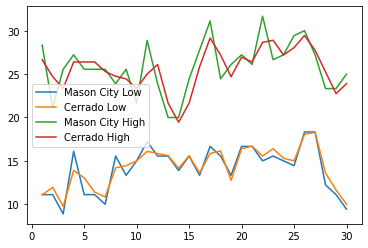

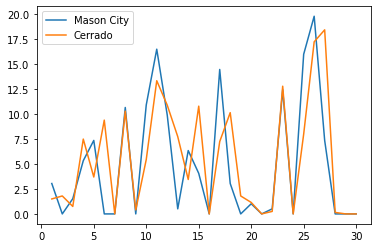

,DAY,TMAX,HIGH
0,1,26.65,28.333333
1,2,24.70,21.111111
2,3,23.35,25.555556
3,4,26.40,27.222222
4,5,26.40,25.555556
5,6,26.40,25.555556
6,7,25.30,25.555556
7,8,24.75,23.888889
8,9,24.45,25.555556
9,10,23.35,21.666667


In [8]:
verf = pd.read_csv('../data/wx/mason_6_2010.csv')
def f_to_c(f):
    return (f - 32) * 5 / 9

def in_to_mm(inch):
    return inch * 25.4

verf.LOW = verf.LOW.map(f_to_c)
verf.HIGH = verf.HIGH.map(f_to_c)
verf.NLOW = verf.NLOW.map(f_to_c)
verf.NHIGH = verf.NHIGH.map(f_to_c)
verf.RECLOW = verf.RECLOW.map(f_to_c)
verf.RECHIGH = verf.RECHIGH.map(f_to_c)

verf.PRCP = verf.PRCP.map(in_to_mm)
verf.RECPRCP = verf.RECPRCP.map(in_to_mm)

tt = tempdf[(tempdf.YEAR == 2010) & (tempdf.MONTH == 6)]
plt.plot(range(1,31), verf.LOW, label='Mason City Low')
plt.plot(range(1,31), tt.TMIN, label='Cerrado Low')
plt.plot(range(1,31), verf.HIGH, label='Mason City High')
plt.plot(range(1,31), tt.TMAX, label='Cerrado High')
plt.legend()
plt.show()

pp = prcpdf[(prcpdf.YEAR == 2010) & (prcpdf.MONTH == 6)]
plt.plot(range(1,31), verf.PRCP, label='Mason City')
plt.plot(range(1,31), pp.PRCP, label='Cerrado')
plt.legend()
plt.show()
verf['DAY'] = verf.ID
tt.merge(verf, on='DAY')[['DAY', 'TMAX', 'HIGH']]

In [9]:
'''
GSP
'''
GSP = prcpseasdf[['YEAR', 'PRCP']].groupby('YEAR').agg(np.mean)

In [10]:
'''
GDD
'''
GDD = tempseasdf.copy()
GDD['GDD'] = (GDD.TMAX + GDD.TMIN) * 0.5 - 10.0
GDD = GDD[['YEAR', 'GDD']].groupby('YEAR').agg(sum)

In [11]:
'''
GSTmax
GSTmin
'''
GSTmax = tempseasdf[['YEAR', 'TMAX']].groupby('YEAR').agg(np.mean)
GSTmin = tempseasdf[['YEAR', 'TMIN']].groupby('YEAR').agg(np.mean)


In [12]:
'''
frost
'''
tempseasdf['FROSTY'] = tempseasdf.TMIN < 0
frost = tempseasdf[['YEAR', 'FROSTY']].groupby('YEAR').agg(sum)

In [13]:
'''
summer
'''
tempseasdf['SUMMER'] = tempseasdf.TMAX > 25
summer = tempseasdf[['YEAR', 'SUMMER']].groupby('YEAR').agg(sum)
summer

,SUMMER
YEAR,
1941,94
1942,81
1943,80
1944,91
1945,66
...,...
2011,92
2012,107
2013,82


In [14]:
'''
CWI/HWI
'''
t = time.time()
tmax90 = []
tmin10 = []
s5cd = {}
for (m, d) in season_days:
    s = sample_5cd(tempdf, m, d, 1961, 1991)
    s5cd[m*32+d] = s
    tmax90.append(s.TMAX.quantile(0.9))
    tmin10.append(s.TMIN.quantile(0.1))
    
hwi = []
cwi = []
for year in range(1941, 2016):
    print(year, time.time() - t)
    tmax = tempseasdf[tempseasdf.YEAR == year].TMAX
    tmin = tempseasdf[tempseasdf.YEAR == year].TMIN
    if year < 1961 or year > 1990:
        toohot = [x > y for (x,y) in zip(tmax, tmax90)]
        hwi.append(sum(toohot))
        toocold = [x < y for (x,y) in zip(tmin, tmin10)]
        cwi.append(sum(toocold))
    else:
        tminboot = []
        tmaxboot = []
        for repl in range(1961, 1991):
            if repl == year:
                continue
            retmax90 = []
            retmin10 = []
            for (m, d) in season_days:
                base = s5cd[m*32+d]
                base = base[base.YEAR != year]
                resampled = base.append(base[base.YEAR == repl])
                retmax90.append(resampled.TMAX.quantile(0.9))
                retmin10.append(resampled.TMIN.quantile(0.1))
            retmax = sum([x > y for (x,y) in zip(tmax, retmax90)])
            retmin = sum([x < y for (x,y) in zip(tmin, retmin10)])
            tmaxboot.append(retmax)
            tminboot.append(retmin)
        hwi.append(np.mean(tmaxboot))
        cwi.append(np.mean(tminboot))
            
HWI = pd.DataFrame({'HWI': hwi}, range(1941, 2016))
CWI = pd.DataFrame({'CWI': cwi}, range(1941, 2016))

print(time.time()-t)

1941 6.240054368972778
1942 6.242367267608643
1943 6.24425745010376
1944 6.246280193328857
1945 6.248265027999878
1946 6.250263214111328
1947 6.252857446670532
1948 6.255310297012329
1949 6.260556697845459
1950 6.264025926589966
1951 6.266378879547119
1952 6.268724203109741
1953 6.271941900253296
1954 6.275176286697388
1955 6.277903318405151
1956 6.280527830123901
1957 6.283160448074341
1958 6.28583288192749
1959 6.288235187530518
1960 6.290703058242798
1961 6.293218374252319
1962 20.4166157245636
1963 34.65723133087158
1964 48.90988492965698
1965 63.163732051849365
1966 77.60396599769592
1967 91.92250633239746
1968 106.28257393836975
1969 120.56918144226074
1970 135.02248787879944
1971 149.09177684783936
1972 163.44279527664185
1973 177.63002467155457
1974 191.8678333759308
1975 205.8615162372589
1976 219.84926652908325
1977 233.83192539215088
1978 247.95501565933228
1979 261.918251991272
1980 275.9668254852295
1981 289.94873332977295
1982 304.2784974575043
1983 318.58051586151123
198

<AxesSubplot:>

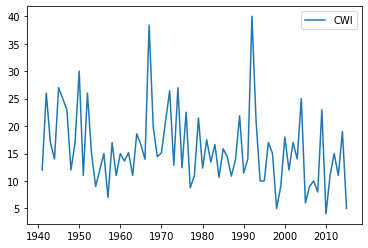

In [15]:
CWI.plot()


In [16]:
'''
dry/wet
'''
prcpseasdf['DRY'] = prcpseasdf.PRCP < 1 
prcpseasdf['WET'] = prcpseasdf.PRCP >= 1
dry = prcpseasdf[['YEAR', 'DRY']].groupby('YEAR').agg(lambda s: streak(s))
wet = prcpseasdf[['YEAR', 'WET']].groupby('YEAR').agg(lambda s: streak(s))

In [17]:
'''
PRCP95P
''' 
wet_days = prcpseasdf[(prcpseasdf.YEAR >= 1961) & (prcpseasdf.YEAR < 1991) & (prcpseasdf.PRCP >= 1)]
RRwn95 = wet_days.PRCP.quantile(0.95)
PRCP95P = prcpseasdf[['YEAR', 'PRCP']].groupby('YEAR').agg(lambda x: x[x > RRwn95].count())


In [18]:
df = pd.DataFrame({
    'YEAR': range(1941, 2016), 
    'GSP': GSP.PRCP, 
    'GDD': GDD.GDD, 
    'GSTmin': GSTmin.TMIN, 
    'GSTmax': GSTmax.TMAX, 
    'frost': frost.FROSTY,
    'summer': summer.SUMMER,
    'HWI': HWI.HWI,
    'CWI': CWI.CWI,
    'dry': dry.DRY,
    'wet': wet.WET,
    'PRCP95P': PRCP95P.PRCP,
})
df.to_csv('../data/wx/wx-frontier-agg-3.csv')

In [19]:
df = frostdf.merge(corn, on='YEAR')
c = []
for n in range(1000):
    samples = df.sample(frac=0.8)
    c.append(samples[['FROSTY', 'YIELD']].corr().FROSTY.YIELD)
pstar = np.mean(c)
p = df.corr().FROSTY.YIELD
bias = pstar - p
pbar = p - bias
print('frost corr', pbar)

NameError: name 'frostdf' is not defined